This will demonstrate how to achieve a constant concentration $[S]_\mathrm{eq}$ of S particles, where the value of $[S]_\mathrm{eq}$ can be roughly adjusted under some approximations.

Define reactions of substrate with factory particles F

$$F \rightleftharpoons F + S$$ 

with forward propensity (intrinsic rate constant) $f_+$ and backward propensity $f_-$. The according macroscopic rates of these processes would be $k_+$ and $k_-$. In equilibrium under assumption of the law of mass action [1]:

$$
K = \frac{[F]_\mathrm{eq}[S]_\mathrm{eq}}{[F]_\mathrm{eq}} = [S]_\mathrm{eq}
$$

The equilibrium constant also relates $k_+$ and $k_-$, which are functions of the propensities $f_+$ and $f_-$ respectively:

$$
K = \frac{k_+(f_+)}{k_-(f_-)}
$$

Since the "$+$" reaction is unimolecular we have $k_+=f_+$. The "$-$" reaction depends on the choice of reaction model. Here we choose the Doi model. Furthermore in equilibrium the effective "$-$" rate does not depend on diffusion and we can formulate it for a dilute system(well described by an isolated pair, see [2]) and in the absence of potentials yielding $k_-= f_- V_R$. The reaction volume is spherical $V_R=\frac{4}{3}\pi R^3$ with reaction radius $R$.
Combining the equations above gives the constant concentration

$$
[S]_\mathrm{eq} = \frac{f_+}{f_- V_R}
$$

- [1] Atkins, Peter; de Paula, Julio: _Atkins’ physical chemistry_, Oxford University Press, 2006 
- [2] Fröhner, Christoph; Noé, Frank: _Reversible interacting-particle reaction dynamics._ The Journal of Physical Chemistry B, 122.49 (2018): 11240-11250.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import readdy

print(readdy.__version__)

v2.0.3-27


In [2]:
factory_minus_rate = 0.08
factory_plus_rate = 0.1
factory_reaction_radius = 0.5
factory_reaction_volume = 4./3. * np.pi * factory_reaction_radius**3

concentration = factory_plus_rate / factory_minus_rate / factory_reaction_volume
print(concentration)

2.3873241463784303


In [3]:
system = readdy.ReactionDiffusionSystem(
    box_size=[10.,10.,10.], 
    periodic_boundary_conditions=[True, True, True],
    unit_system=None
)

system.add_species("S", 1.)
system.add_species("F", 1.)

system.reactions.add_fusion(
    "factory-fusion", "F", "S", "F", factory_minus_rate,
    factory_reaction_radius, weight1=0., weight2=1.)
system.reactions.add_fission(
    "factory-fission", "F", "F", "S", factory_plus_rate,
    factory_reaction_radius, weight1=0., weight2=1.)

In [4]:
simulation = system.simulation("SingleCPU", reaction_handler="UncontrolledApproximation")
simulation.observe.number_of_particles(1, types=["S", "F"])
simulation.output_file = "const_concentration.h5"

if os.path.exists(simulation.output_file):
    os.remove(simulation.output_file)

simulation.add_particles("F", np.random.uniform(size=(1000,3)) * 10. - 5.)

timestep = 5e-3
simulation.run(50000, timestep)

  0%|          | 11/5000 [00:00<00:48, 103.50it/s]

Configured kernel context with:
--------------------------------
 - kBT = 1.0
 - periodic b.c. = (true, true, true)
 - box size = (10.0, 10.0, 10.0)
 - particle types:
     *  particle type "F" with D=1.0
     *  particle type "S" with D=1.0
 - unimolecular reactions:
     * Fission F -> F + S with a rate of 0.1, a product distance of 0.5, and weights 0.0 and 1.0
 - bimolecular reactions:
     * Fusion F + S -> F with a rate of 0.08, an educt distance of 0.5, and weights 0.0 and 1.0

Configured simulation loop with:
--------------------------------
 - timeStep = 0.00500000
 - evaluateObservables = true
 - progressOutputStride = 100
 - context written to file = true
 - Performing actions:
   * Initialize neighbor list? true
   * Update neighbor list? true
   * Clear neighbor list? true
   * Integrate diffusion? true
   * Calculate forces? true
   * Handle reactions? true
   * Handle topology reactions? true



100%|██████████| 5000/5000 [02:39<00:00, 31.29it/s]


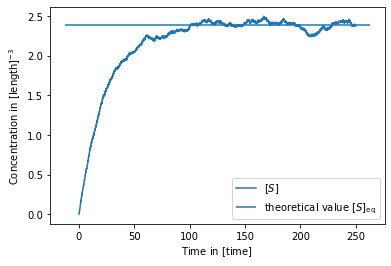

In [6]:
traj = readdy.Trajectory(simulation.output_file)
time, counts = traj.read_observable_number_of_particles()

volume = 10**3
plt.plot(time * timestep, counts[:,0]/volume, label=r"$[S]$")
plt.hlines(concentration, *plt.xlim(), label=r"theoretical value $[S]_\mathrm{eq}$")
plt.legend(loc="lower right")
plt.xlabel(r"Time in $[\mathrm{time}]$")
plt.ylabel(r"Concentration in $[\mathrm{length}]^{-3}$")
plt.show()